In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
from scipy.special import erf

In [3]:
class deep3RBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,variance3=1.,active_dims=None):
        super(deep3RBF, self).__init__(input_dim, active_dims, 'deep3rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.variance3 = Param('variance3',variance3)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2, self.variance3)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 2.*(1.-np.exp((-1.)*dist2/2.))+0.000001
        tmp2 = 1./np.sqrt(tmp1)/self.variance1
        tmp3 = erf(tmp2)
        return self.variance3/np.sqrt(1+2.*self.variance2)*(1-tmp3)+self.variance3*tmp3
    
    def Kdiag(self,X):
        return self.variance3*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 2.*(1.-np.exp((-1.)*dist2/2.))+0.000001
        tmp2 = 1./np.sqrt(tmp1)/self.variance1
        tmp3 = erf(tmp2)
        #tmp1 = 1.-np.exp((-1.)*dist2/2.)
        #tmp2 = 2.*self.variance1*tmp1

        dvar3 = 1./np.sqrt(1+2.*self.variance2)*(1-tmp3)+tmp3
        dvar2 = 2.*self.variance3/(1+2.*self.variance2)**(1.5)*(1-tmp3)
        
        dvar1 = 2.*self.variance3/self.variance1/np.sqrt(np.pi)*np.exp((-1.)*tmp2**2)*tmp2*(-1.+1/np.sqrt(1+2.*self.variance2))
        
        dl_1 = self.variance3*self.variance1**2/self.lengthscale*(1-1/np.sqrt(1+2*self.variance2))/np.sqrt(np.pi)
        dl_2 = np.exp(-1.*tmp2**2)*tmp2**3*np.exp((-0.5)*dist2)*dist2
        dl = dl_1*dl_2
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        #dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        #dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lengthscale2.gradient = np.sum(dl2*dL_dK)
        self.variance3.gradient = np.sum(dvar3*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance3.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        pass
        #if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        #dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        #tmp1 = 1.-np.exp((-1.)*dist2/2.)
        #tmp2 = 2.*self.variance1*tmp1
        #tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        #dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass

 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:covariance is not positive-semidefinite.


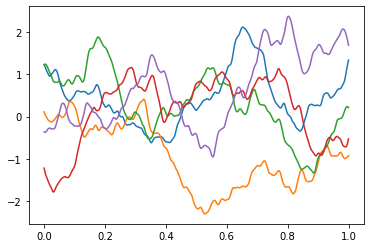

In [4]:
k = deep3RBF(input_dim=1,variance1=4.,lengthscale=0.25,variance2=3.5,variance3=1.)
xx = np.linspace(0,1,500).reshape(-1,1)
mu = np.zeros(xx.shape[0])

C = k.K(xx,xx)

Z = np.random.multivariate_normal(mu,C,5)

for i in range(5):
    plt.plot(xx[:],Z[i,:])
plt.show()

In [5]:
import pandas as pd

auto_df = pd.read_csv('Auto.csv',na_values='?').dropna()

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = auto_df[['horsepower','displacement','weight','acceleration','mpg']].values

X = data[:,0:4]
y = data[:,-1].reshape(-1,1)

X_stz = StandardScaler().fit_transform(X)
y_stz = StandardScaler().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_stz, y_stz, test_size=0.2)

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [8]:
rbf3 = deep3RBF(input_dim=X_train.shape[1])
m2 = GPy.models.GPRegression(X_train, y_train,rbf3)
m2.optimize()

 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning:invalid value encountered in sqrt
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning:invalid value encountered in sqrt
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning:invalid value encountered in power
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning:invalid value encountered in sqrt
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning:invalid value encountered in sqrt


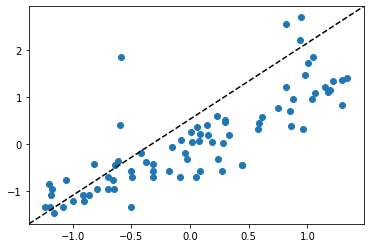

In [9]:
m2f_t, m2v_t = m2.predict(X_test)
m2f_tr, m2v_tr = m2.predict(X_train)

plt.scatter(m2f_t,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

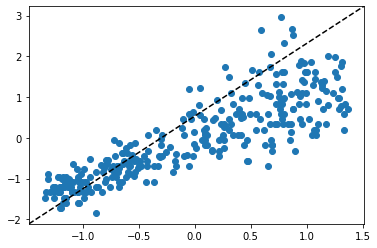

In [10]:
plt.scatter(m2f_tr,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

In [11]:
print(rmse(m2f_t,y_test))

0.5564156421057936


In [12]:
print(rmse(m2f_tr,y_train))

0.5183893395773581


In [13]:
print(compute_nll(y_test,m2f_t,m2v_t))

2.084147359464341


In [14]:
print(compute_nll(y_train,m2f_tr,m2v_tr))

2.2237572575891296


In [15]:
print(m2)


Name : GP regression
Objective : 286.97386205888733
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  deep3rbf.variance1       |  1.0770523228013444  |               |        
  deep3rbf.lengtscale      |  1.1479200308789324  |               |        
  deep3rbf.variance2       |  0.8564133542607408  |               |        
  deep3rbf.variance3       |   1.150487191589199  |               |        
  Gaussian_noise.variance  |  0.5040545145548073  |      +ve      |        


In [16]:
print(m2.kern.variance1[0])

1.0770523228013444


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:covariance is not positive-semidefinite.


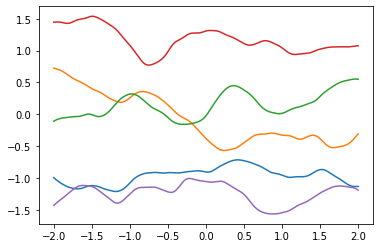

In [17]:
kk = deep3RBF(input_dim=1,variance1=m2.kern.variance1[0],lengthscale=m2.kern.lengthscale[0],variance2=m2.kern.variance2[0],variance3=m2.kern.variance3[0])
xx = np.linspace(-2,2,500).reshape(-1,1)
mu = np.zeros(xx.shape[0])

C = kk.K(xx,xx)

Z = np.random.multivariate_normal(mu,C,5)

for i in range(5):
    plt.plot(xx[:],Z[i,:])
plt.show()